In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
path_hr = "HR/" 
path_lr = "LR/" 

In [3]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
#print(src.name)

In [4]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr+x.name)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=False
                                                     ))

    data.c = 3
    return data

In [5]:
#bs,size=1, 512
# bs,size = 24,160
bs,size = 2,400
arch = models.resnet34

In [6]:
data_gen = get_data(bs,size)

In [7]:
print(data_gen)

ImageDataBunch;

Train: LabelList (720 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: LR;

Valid: LabelList (80 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: LR;

Test: None


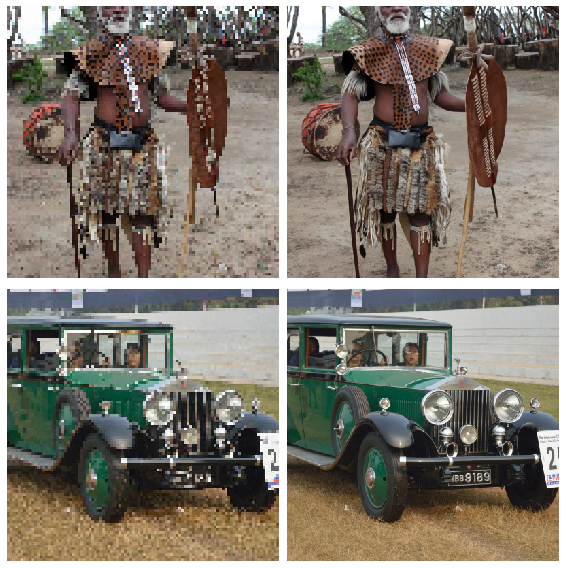

In [8]:
data_gen.show_batch(5)

In [9]:
wd = 1e-1
y_range = (-3.,3.)
loss_gen = MSELossFlat()
arch = models.resnet34

In [10]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=feat_loss)

Feature Loss


In [11]:
t = data_gen.valid_ds[0][1].data
t = torch.stack([t,t])

In [12]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [13]:
gram_matrix(t)

tensor([[[0.0893, 0.0984, 0.1007],
         [0.0984, 0.1098, 0.1121],
         [0.1007, 0.1121, 0.1175]],

        [[0.0893, 0.0984, 0.1007],
         [0.0984, 0.1098, 0.1121],
         [0.1007, 0.1121, 0.1175]]])

In [14]:
base_loss = F.l1_loss

In [15]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

Training


In [ ]:
learn_gen = None
learn_gen = create_gen_learner()

In [ ]:
lr = learn_gen.lr_find()

In [21]:
print(lr)

None


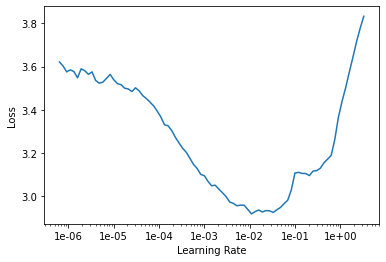

In [22]:
learn_gen.recorder.plot()

In [23]:
learn_gen.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,1.575009,1.577769,06:32
1,1.370300,1.362492,06:38
2,1.326324,1.325538,07:00
3,1.298339,1.292977,07:03
4,1.281962,1.300330,07:04
5,1.268209,1.271868,07:04
6,1.241413,1.255944,07:04
7,1.264969,1.253357,07:04
8,1.215031,1.245046,07:06
9,1.223146,1.243574,07:06


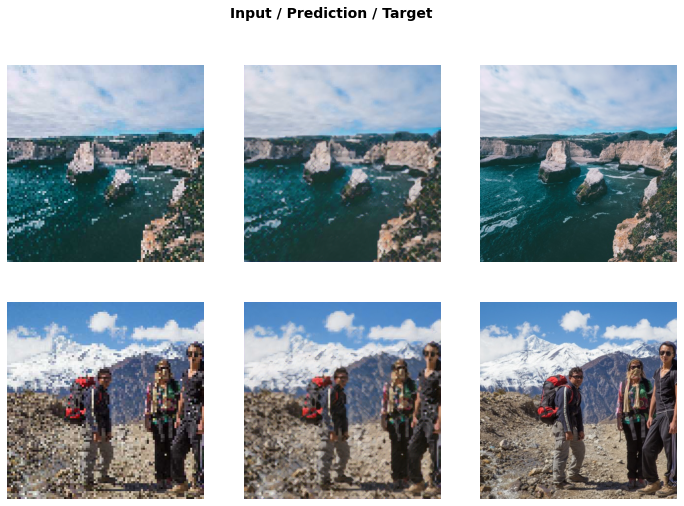

In [24]:
learn_gen.show_results(rows=5)

In [21]:
learn_gen.unfreeze()

In [21]:
learn_gen.fit_one_cycle(10, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,1.228729,1.249670,06:46
1,1.240535,1.260232,06:51
2,1.255070,1.280712,06:54
3,1.232889,1.258378,06:58
4,1.271045,1.256363,06:36
5,1.237456,1.253612,06:28
6,1.246369,1.246175,06:28
7,1.213146,1.239031,06:28
8,1.212088,1.235413,06:28
9,1.215762,1.233827,06:29


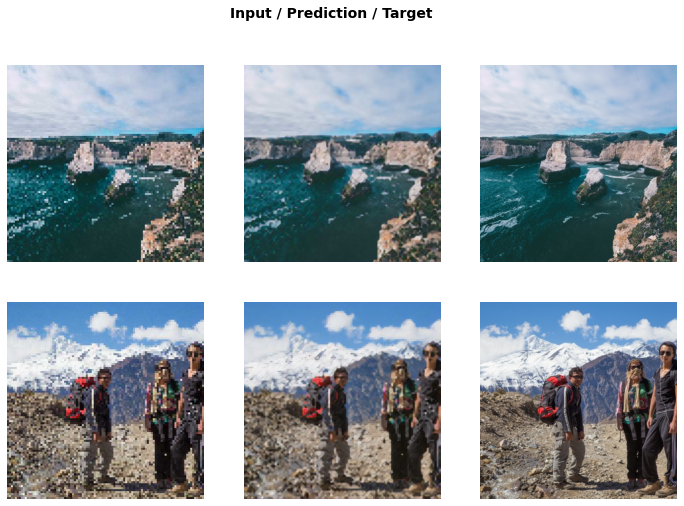

In [22]:
learn_gen.show_results(rows=5)

In [23]:
learn_gen.save('u-net-feat')

Upload the test data

In [ ]:
learn_gen.load('u-net-feat');

In [ ]:
source = "resized/" 

In [ ]:
test_data = ImageImageList.from_folder(source)

In [ ]:
print(test_data)

In [ ]:
learn_gen.data.add_test(test_data, tfm_y=False)

In [ ]:
import shutil


def remove_dir(name):
  try:
      shutil.rmtree(name)
  except OSError:
      print ("Couldn't remove the directory")
  else:
      print ("Successfully removed the directory")

In [ ]:
import os

def create_dir(name):
  #rm -rf name
  # define the name of the directory to be created
  try:
      os.mkdir(name)
  except OSError:
      print ("Creation of the directory failed")
  else:
      print ("Successfully created the directory")

In [ ]:
preds = []
num = len(learn_gen.data.test_ds)
dest = 'Unet/'

remove_dir(dest)
create_dir(dest)

for i in range(num):
  filename = str(learn_gen.data.test_ds.items[i]).split('/')[-1]
  p = learn_gen.predict(data_gen.test_ds.x[i])
  prediction = p[0]
  prediction.save(dest + filename)
  preds.append(p[0])